In [ ]:
# === Lightning Module для обучения ===
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

class ToxicClassifierModule(pl.LightningModule):
    def __init__(self, model, num_classes=3, lr=1e-3):
        super().__init__()
        self.model = model
        self.num_classes = num_classes
        self.lr = lr
        self.criterion = nn.CrossEntropyLoss()
        
        # Для метрик
        self.train_preds = []
        self.train_labels = []
        self.val_preds = []
        self.val_labels = []
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        
        # Сохраняем предсказания для метрик
        preds = torch.argmax(logits, dim=1)
        self.train_preds.extend(preds.cpu().numpy())
        self.train_labels.extend(y.cpu().numpy())
        
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        
        # Сохраняем предсказания для метрик
        preds = torch.argmax(logits, dim=1)
        self.val_preds.extend(preds.cpu().numpy())
        self.val_labels.extend(y.cpu().numpy())
        
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss
    
    def on_validation_epoch_end(self):
        # Вычисляем метрики
        if self.val_preds:
            acc = accuracy_score(self.val_labels, self.val_preds)
            f1 = f1_score(self.val_labels, self.val_preds, average='macro')
            
            self.log('val_accuracy', acc, prog_bar=True)
            self.log('val_f1', f1, prog_bar=True)
            
            # Очищаем списки для следующей эпохи
            self.val_preds.clear()
            self.val_labels.clear()
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

# === Функция обучения с Lightning ===
def train_model_lightning(model, train_loader, test_loader, epochs=5, lr=1e-3):
    # Создаем Lightning модуль
    lightning_model = ToxicClassifierModule(model, lr=lr)
    
    # Callbacks
    early_stop = EarlyStopping(
        monitor='val_accuracy',
        patience=3,
        mode='max',
        verbose=True
    )
    
    checkpoint = ModelCheckpoint(
        monitor='val_accuracy',
        mode='max',
        save_top_k=1,
        filename='best-model-{epoch:02d}-{val_accuracy:.2f}'
    )
    
    # Logger
    logger = TensorBoardLogger("lightning_logs", name="toxic_classifier")
    
    # Trainer
    trainer = pl.Trainer(
        max_epochs=epochs,
        callbacks=[early_stop, checkpoint],
        logger=logger,
        accelerator='auto',
        devices=1,
        precision=16 if torch.cuda.is_available() else 32
    )
    
    # Обучение
    trainer.fit(lightning_model, train_loader, test_loader)
    
    # Тестирование
    test_results = trainer.test(lightning_model, test_loader)
    
    # Получаем финальные метрики
    final_accuracy = test_results[0]['test_val_accuracy']
    final_f1 = test_results[0]['test_val_f1']
    
    print(f"\nFinal Results:")
    print(f"Accuracy: {final_accuracy:.4f}")
    print(f"Macro-F1: {final_f1:.4f}")
    
    return final_accuracy, final_f1, None


In [7]:
import random
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
import fasttext.util
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import pandas as pd
import re
from sklearn.metrics import f1_score, classification_report

In [8]:
dataset = pd.read_csv('eng_toxic_full_df.csv')
columns = ['comment_text', 'neutral', 'toxic_not_threat', 'toxic_threat']
dataset = dataset[columns]
dataset


,comment_text,neutral,toxic_not_threat,toxic_threat
0,Explanation\nWhy the edits made under my usern...,1,0,0
1,D'aww! He matches this background colour I'm s...,1,0,0
2,"Hey man, I'm really not trying to edit war. It...",1,0,0
3,"""\nMore\nI can't make any real suggestions on ...",1,0,0
4,"You, sir, are my hero. Any chance you remember...",1,0,0
...,...,...,...,...
159566,""":::::And for the second time of asking, when ...",1,0,0
159567,You should be ashamed of yourself \n\nThat is ...,1,0,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",1,0,0
159569,And it looks like it was actually you who put ...,1,0,0


**Лингвистический анализ датасета**

In [6]:
from textstat import flesch_reading_ease
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import words


# 1. Полнота данных
def data_completeness(df):
    total_cells = df.size
    missing_cells = df.isnull().sum().sum()
    completeness = ((total_cells - missing_cells) / total_cells) * 100
    return completeness

# 2. Лексическое разнообразие
def lexical_diversity(text):
    if pd.isna(text) or text == '':
        return 0
    words = text.lower().split()
    if len(words) == 0:
        return 0
    return len(set(words)) / len(words)

# 3. Уровень читаемости
def readability_score(text):
    if pd.isna(text) or text == '':
        return 0
    try:
        return flesch_reading_ease(text)
    except:
        return 0

# 4. Структурная целостность
def structural_integrity(text):
    if pd.isna(text) or text == '':
        return 0
    
    # Проверяем наличие пунктуации и структуры
    has_punctuation = any(char in text for char in ['.', '!', '?'])
    has_capitalization = any(char.isupper() for char in text)
    word_count = len(text.split())
    
    score = 0
    if has_punctuation: score += 0.3
    if has_capitalization: score += 0.3
    if word_count >= 3: score += 0.4
    
    return score

# 5. Отсутствие шума
def noise_level(text):
    if pd.isna(text) or text == '':
        return 1  # Пустой текст считается чистым
    
    # Ищем признаки шума: повторяющиеся символы, капс и т.д.
    noise_indicators = 0
    
    # Повторяющиеся символы (более 3 подряд)
    if re.search(r'(.)\1{3,}', text):
        noise_indicators += 1
    
    # Чрезмерное использование заглавных букв
    if len(text) > 10:
        upper_ratio = sum(1 for char in text if char.isupper()) / len(text)
        if upper_ratio > 0.5:
            noise_indicators += 1
    
    # Слишком короткие или длинные слова
    words = text.split()
    if words:
        unusual_words = sum(1 for word in words if len(word) > 20 or len(word) == 1)
        if unusual_words / len(words) > 0.3:
            noise_indicators += 1
    
    return 1 - (noise_indicators / 3)

# 6. Лингвистическая корректность (упрощенная версия)
def linguistic_correctness(text):
    if pd.isna(text) or text == '':
        return 0
    
    try:
        # Простая проверка на английские слова
        english_words = set(words.words())
        text_words = re.findall(r'\b[a-zA-Z]+\b', text.lower())
        
        if not text_words:
            return 0
        
        # Процент слов, которые есть в английском словаре
        valid_words = sum(1 for word in text_words if word in english_words)
        return valid_words / len(text_words)
    except:
        return 0.5  # Среднее значение при ошибке

# Функция для определения уровня качества
def get_quality_level(score):
    if score >= 90:
        return "отличный"
    elif score >= 80:
        return "хороший"
    elif score >= 70:
        return "средний"
    elif score >= 60:
        return "удовлетворительный"
    else:
        return "низкий"

# Вычисление метрик для всего датасета
print("=== АНАЛИЗ ДАТАСЕТА ===")
print(f"Всего записей: {len(dataset)}")

# Полнота данных
completeness = data_completeness(dataset)
print(f"\n1. Полнота данных: {completeness:.2f}%")

# Лексическое разнообразие (только для текстовых колонок)
lex_div = dataset['comment_text'].apply(lexical_diversity).mean()
print(f"2. Среднее лексическое разнообразие: {lex_div:.3f}")

# Уровень читаемости
readability = dataset['comment_text'].apply(readability_score).mean()
print(f"3. Средний уровень читаемости: {readability:.2f}")

# Структурная целостность
structure = dataset['comment_text'].apply(structural_integrity).mean()
print(f"4. Средняя структурная целостность: {structure:.3f}")

# Отсутствие шума
noise_free = dataset['comment_text'].apply(noise_level).mean()
print(f"5. Средний уровень отсутствия шума: {noise_free:.3f}")

# Лингвистическая корректность
linguistic = dataset['comment_text'].apply(linguistic_correctness).mean()
print(f"6. Средняя лингвистическая корректность: {linguistic:.3f}")

# Дополнительная статистика
print(f"\n=== ДОПОЛНИТЕЛЬНАЯ СТАТИСТИКА ===")
print(f"Средняя длина комментария: {dataset['comment_text'].str.len().mean():.1f} символов")
print(f"Среднее количество слов: {dataset['comment_text'].str.split().str.len().mean():.1f}")

# Расчет итоговой оценки качества данных
print(f"\n=== ИТОГОВАЯ ОЦЕНКА КАЧЕСТВА ДАННЫХ ===")

# Нормализуем показатели к шкале 0-100
metrics = {
    "Полнота данных": completeness,  # уже в процентах
    "Лексическое разнообразие": lex_div * 100,  # из 0-1 в 0-100
    "Уровень читаемости": min(readability, 100),  # ограничиваем максимум 100
    "Структурная целостность": structure * 100,  # из 0-1 в 0-100
    "Отсутствие шума": noise_free * 100,  # из 0-1 в 0-100
    "Лингвистическая корректность": linguistic * 100  # из 0-1 в 0-100
}

# Выводим нормализованные показатели
print("\nНормализованные показатели (0-100):")
for metric, value in metrics.items():
    print(f"  {metric}: {value:.1f}")

# Взвешенная итоговая оценка (можно настроить веса)
weights = {
    "Полнота данных": 0.15,  # самый важный показатель
    "Лексическое разнообразие": 0.15,
    "Уровень читаемости": 0.20,
    "Структурная целостность": 0.15,
    "Отсутствие шума": 0.15,
    "Лингвистическая корректность": 0.20
}

# Расчет итоговой оценки
total_score = sum(metrics[metric] * weight for metric, weight in weights.items())
quality_level = get_quality_level(total_score)

print(f"\n ОБЩАЯ ОЦЕНКА КАЧЕСТВА ДАННЫХ - {total_score:.1f} из 100 баллов, "
      f"что соответствует {quality_level} уровню.")



=== АНАЛИЗ ДАТАСЕТА ===
Всего записей: 159571

1. Полнота данных: 100.00%
2. Среднее лексическое разнообразие: 0.843
3. Средний уровень читаемости: 61.50
4. Средняя структурная целостность: 0.963
5. Средний уровень отсутствия шума: 0.964
6. Средняя лингвистическая корректность: 0.500

=== ДОПОЛНИТЕЛЬНАЯ СТАТИСТИКА ===
Средняя длина комментария: 394.1 символов
Среднее количество слов: 67.3

=== ИТОГОВАЯ ОЦЕНКА КАЧЕСТВА ДАННЫХ ===

Нормализованные показатели (0-100):
  Полнота данных: 100.0
  Лексическое разнообразие: 84.3
  Уровень читаемости: 61.5
  Структурная целостность: 96.3
  Отсутствие шума: 96.4
  Лингвистическая корректность: 50.0

 ОБЩАЯ ОЦЕНКА КАЧЕСТВА ДАННЫХ - 78.9 из 100 баллов, что соответствует средний уровню.


**Посмотрим на распределение классов в датасете**

In [9]:
x = dataset['comment_text']
y = dataset[['neutral', 'toxic_not_threat', 'toxic_threat']]
print(y['neutral'].value_counts())
print(y['toxic_not_threat'].value_counts())
print(y['toxic_threat'].value_counts())

neutral
1    143346
0     16225
Name: count, dtype: int64
toxic_not_threat
0    143824
1     15747
Name: count, dtype: int64
toxic_threat
0    159093
1       478
Name: count, dtype: int64


In [10]:
neutral_df = dataset[dataset['neutral'] == 1].sample(n=15000)
toxic_not_threat_df = dataset[dataset['toxic_not_threat'] == 1].sample(n=15000)
toxic_threat_df = dataset[dataset['toxic_threat'] == 1]
balanced_dataset = pd.concat([neutral_df, toxic_not_threat_df, toxic_threat_df], axis=0)
balanced_dataset = balanced_dataset.sample(frac=1, random_state=42).reset_index(drop=True)
balanced_dataset

,comment_text,neutral,toxic_not_threat,toxic_threat
0,"Dear Piotrus,\n\nhe's a stupid illiterate from...",0,1,0
1,I HATE YOU NOOB \n\nYOU OLD PILE OF !@#$ING @^...,0,1,0
2,"I definitely must disagree ... in particular, ...",1,0,0
3,AH HAAHHAHAHAH YAAA BITCH YAAAA!@!!!!!!AH HAAH...,0,1,0
4,"""\n\n Relevance of """"Academics fear speaking f...",1,0,0
...,...,...,...,...
30473,Who the hell said I was experimenting? You too...,0,1,0
30474,""", 10 August 2010 (UTC)\nIndeed, I believe wi...",1,0,0
30475,Julian Green \n\nhttp://de.wikipedia.org/wiki/...,1,0,0
30476,Yes \nAny third party would be able to tell yo...,0,1,0


In [11]:
x = balanced_dataset['comment_text']
y = balanced_dataset[['neutral', 'toxic_not_threat', 'toxic_threat']]
print(y['neutral'].value_counts())
print(y['toxic_not_threat'].value_counts())
print(y['toxic_threat'].value_counts())

neutral
0    15478
1    15000
Name: count, dtype: int64
toxic_not_threat
0    15478
1    15000
Name: count, dtype: int64
toxic_threat
0    30000
1      478
Name: count, dtype: int64


**Датасет несбалансированный, только 478 примеров на 3 класс. В то же время формирование датасета объемом в 1500-2000 демонстрирует менее удовлетворительные метрики качества, чем несбалансированный датасет, но большего объема**

In [12]:
y = y.idxmax(axis=1).map({'neutral': 0, 'toxic_not_threat': 1, 'toxic_threat': 2}).values
print("labels shape:", y.shape)
print("Пример меток:", y[:5])

labels shape: (30478,)
Пример меток: [1 1 0 1 0]


In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True)


In [14]:
y_test.shape

(6096,)

In [15]:
x_test.shape

(6096,)

**Здесь мы вынуждены разбивать на чанки без из подачи в итеративную функцию, т.к. любой итератор зависает. Таким образом, будем трансформировать каждый чанк в эбеддинги через отдельный запуск**

In [16]:
x_train

11762         wtf? this aint me! who the fuck used ma ip?!
609      Lots of Mormons in the edit crowd, I think, th...
22758    "\n\n Uh I hate to break it to you but Jusdafa...
17486                             Bongwarrior is a faggot.
2963     "\n\n My Statement \n\nOh wow, I take a little...
                               ...                        
18419    LMAO so you reported me ahahahahahahahahahahah...
602      Sir \n\nThank for your reply. But I thought I ...
4403      FUCK YOU DIRTY INDIAN... \n\nSHYT HEAD INDIAN!!!
3206             Oh... I.. yeah i feel like an ass now....
22506    "\n I would appreciate that, although I can't ...
Name: comment_text, Length: 24382, dtype: object

<!-- # === FastText ===
print("\n=== FastText ===")
fasttext.util.download_model('en', if_exists='ignore')
ft = fasttext.load_model('cc.en.300.bin')

def get_text_embedding(text, model, max_len=500):
    words = text.strip().split()[:max_len]  # Обрезаем до max_len слов
    word_vectors = [model.get_word_vector(w) for w in words if w]
    if len(word_vectors) == 0:
        return np.zeros((max_len, model.get_dimension()))  # [max_len, 300]
    word_vectors = np.array(word_vectors)  # [len(words), 300]
    pad_len = max_len - len(word_vectors)
    word_vectors = np.pad(word_vectors, ((0, pad_len), (0, 0)), mode='constant')  # [max_len, 300]
    return word_vectors

X_train_ft = np.array([get_text_embedding(s, ft) for s in x_train])  # [N, max_len, 300] -->


In [17]:
x_1 = x_train[:2000]
x_2 = x_train[2000:4000]
x_3 = x_train[4000:6000]
x_4 = x_train[6000:8000]
x_5 = x_train[8000:10000]
x_6 = x_train[10000:12000]
x_7 = x_train[12000:14000]
x_8 = x_train[14000:16000]
x_9 = x_train[16000:18000]
x_10 = x_train[18000:20000]
x_11 = x_train[20000:22000]
x_12 = x_train[22000:24000]

**Далее проводим предобработку датасета и преобразование чанков в эмбеддинги**

In [18]:
# === FastText ===
print("\n=== FastText ===")
fasttext.util.download_model('en', if_exists='ignore')
ft = fasttext.load_model('cc.en.300.bin')

def get_text_embedding(text, model, max_len=50):
    text = text.lower()
    text = re.sub(r"[^а-яёa-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    words = text.strip().split()[:max_len]  # Обрезаем до max_len слов
    word_vectors = [model.get_word_vector(w) for w in words if w]
    if len(word_vectors) == 0:
        return np.zeros((max_len, model.get_dimension()))  # [max_len, 300]
    word_vectors = np.array(word_vectors)  # [len(words), 300]
    pad_len = max_len - len(word_vectors)
    word_vectors = np.pad(word_vectors, ((0, pad_len), (0, 0)), mode='constant')  # [max_len, 300]
    return word_vectors


=== FastText ===


In [19]:
X_train_ft_1 = np.array([get_text_embedding(s, ft) for s in x_1])

In [20]:
X_train_ft_2 = np.array([get_text_embedding(s, ft) for s in x_2])

In [21]:
X_train_ft_3 = np.array([get_text_embedding(s, ft) for s in x_3])

In [22]:
X_train_ft_4 = np.array([get_text_embedding(s, ft) for s in x_4])

In [23]:
X_train_ft_5 = np.array([get_text_embedding(s, ft) for s in x_5])

In [24]:
X_train_ft_6 = np.array([get_text_embedding(s, ft) for s in x_6])

In [25]:
X_train_ft_7 = np.array([get_text_embedding(s, ft) for s in x_7])

In [26]:
X_train_ft_8 = np.array([get_text_embedding(s, ft) for s in x_8])

In [27]:
X_train_ft_9 = np.array([get_text_embedding(s, ft) for s in x_9])

In [28]:
X_train_ft_10 = np.array([get_text_embedding(s, ft) for s in x_10])

In [29]:
X_train_ft_11 = np.array([get_text_embedding(s, ft) for s in x_11])

In [30]:
X_train_ft_12 = np.array([get_text_embedding(s, ft) for s in x_12])

In [31]:
print([get_text_embedding(s, ft).shape for s in x_12[:5]])


[(50, 300), (50, 300), (50, 300), (50, 300), (50, 300)]


In [32]:
X_train_ft = np.concatenate(
    [X_train_ft_1, X_train_ft_2, X_train_ft_3, X_train_ft_4, 
     X_train_ft_5, X_train_ft_6, X_train_ft_7, X_train_ft_8, 
     X_train_ft_9, X_train_ft_10, X_train_ft_11, X_train_ft_12],
    axis=0
)

In [33]:
X_train_ft

array([[[ 6.4190134e-02, -4.9647424e-02,  1.6147101e-01, ...,
          1.1307117e-01, -1.4400050e-02, -1.2397154e-01],
        [-2.2414971e-02,  9.3033433e-02,  5.8219831e-02, ...,
          2.1794516e-01, -3.0214470e-02,  2.8005324e-02],
        [ 4.2054784e-03, -7.9664446e-02,  1.8153455e-02, ...,
         -9.1123566e-02, -1.1427512e-01, -1.8130140e-01],
        ...,
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00]],

       [[-6.2790564e-03, -6.0419291e-02, -1.6817195e-02, ...,
          2.0341855e-01, -1.2589312e-01, -1.6867779e-02],
        [-7.3038238e-05, -1.8774074e-01, -7.1051158e-02, ...,
          2.8464055e-02, -1.3843335e-01,  1.8053975e-02],
        [-4.8637979e-02, 

In [34]:
X_test_ft = np.array([get_text_embedding(s, ft) for s in x_test])    # [M, 500, 300]


In [35]:
print(X_train_ft[0][:10, :10])

[[ 0.06419013 -0.04964742  0.16147101  0.12415031 -0.06653842 -0.27386272
  -0.03499464 -0.14051698  0.04458542  0.12559581]
 [-0.02241497  0.09303343  0.05821983  0.15150629 -0.00908858 -0.01511977
  -0.04232655 -0.03560359  0.00720556  0.01466874]
 [ 0.00420548 -0.07966445  0.01815346  0.14050502 -0.23633605 -0.04419517
   0.16264741  0.02035538 -0.04073482  0.0323429 ]
 [ 0.18209949 -0.41729486  0.17974643 -0.07757198 -0.05542169 -0.10498718
  -0.22686273 -0.01686647 -0.04318026  0.03244121]
 [-0.0482863  -0.02085951 -0.02114619  0.19326274 -0.16013867 -0.07034816
   0.05852782  0.00307909 -0.00312298  0.0072584 ]
 [-0.05174419  0.07396396 -0.01305688  0.04472656 -0.03432037  0.02121688
   0.00691149 -0.01632785 -0.01807486 -0.00199652]
 [ 0.11961754 -0.17471974  0.11348052  0.13196352 -0.12616706 -0.24028414
  -0.07035875 -0.01981846  0.06133699  0.08418962]
 [-0.00999342  0.07801163 -0.02827924  0.07844038 -0.00318213  0.03527929
  -0.0420055  -0.00827155  0.11588334  0.00607674]


In [36]:
# === TextDataset ===
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)  # [N, max_len, 300]
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 32
train_dataset = TextDataset(X_train_ft, y_train)

In [37]:
test_dataset = TextDataset(X_test_ft, y_test)

In [38]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [39]:
test_loader = DataLoader(test_dataset, batch_size=batch_size)

**Возьмем CNN модель. Будем использовать два вида пуллинга, которые потенциально извлекут значимые признаки из контекста на разных уровнях. Заметим здесь, что такая связка с пуллингами улучшает базовую свертку в части accuracy почти на 30%. Это объясняется высокой значимостью контекста для данного типа задач**

In [40]:
# === TextCNN_FT ===
class TextCNN_FT(nn.Module):
    def __init__(self, embed_dim=300, num_classes=3, kernel_sizes=[3,4,5], num_filters=100, dropout=0.5):
        super().__init__()
        self.convs = nn.ModuleList([nn.Conv1d(embed_dim, num_filters, k) for k in kernel_sizes])
        self.dropout = nn.Dropout(dropout)
        self.bn = nn.BatchNorm1d(num_filters * len(kernel_sizes) * 2)  # *2 для max+avg pooling
        self.fc = nn.Linear(num_filters * len(kernel_sizes) * 2, num_classes)

    def forward(self, x):
        # x: [B, L, E]
        x = x.permute(0, 2, 1)  # [B, E, L]
        convs = [F.relu(conv(x)) for conv in self.convs]  # [B, F, L-k+1]
        pools_max = [F.max_pool1d(c, c.size(2)).squeeze(2) for c in convs]  # [B, F]
        pools_avg = [F.avg_pool1d(c, c.size(2)).squeeze(2) for c in convs]  # [B, F]
        pools = [torch.cat([pm, pa], dim=1) for pm, pa in zip(pools_max, pools_avg)]  # [B, 2F]
        x = torch.cat(pools, dim=1)  # [B, 2F * len(kernel_sizes)]
        x = self.dropout(self.bn(x))
        return self.fc(x)

In [41]:
model = TextCNN_FT(embed_dim=300, num_classes=3)
print(model)

TextCNN_FT(
  (convs): ModuleList(
    (0): Conv1d(300, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(300, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(300, 100, kernel_size=(5,), stride=(1,))
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (bn): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=600, out_features=3, bias=True)
)


**v2 (расширенная версия с Residual connections, задействованная на других проектах в прошлом году), можно запустить на втором проходе, может дать небольшой прирост, но несущественный**

In [43]:
class TextCNN_FT(nn.Module):
    def __init__(self, embed_dim=300, num_classes=3, kernel_sizes=[3, 4, 5], num_filters=128, dropout=0.3):
        super().__init__()
        # Первый набор свёрточных слоёв
        self.convs1 = nn.ModuleList([nn.Conv1d(embed_dim, num_filters, k) for k in kernel_sizes])
        self.bn1 = nn.ModuleList([nn.BatchNorm1d(num_filters) for _ in kernel_sizes])
        # Второй набор свёрточных слоёв
        self.convs2 = nn.ModuleList([nn.Conv1d(num_filters, num_filters, k) for k in kernel_sizes])
        self.bn2 = nn.ModuleList([nn.BatchNorm1d(num_filters) for _ in kernel_sizes])
        # Dropout и BatchNorm для полносвязных слоёв
        self.dropout = nn.Dropout(dropout)
        self.bn_fc = nn.BatchNorm1d(num_filters * len(kernel_sizes) * 2)  # *2 для max+avg pooling
        # Полносвязные слои
        self.fc1 = nn.Linear(num_filters * len(kernel_sizes) * 2, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        # x: [B, L, E]
        x = x.permute(0, 2, 1)  # [B, E, L]
        # Первый свёрточный слой
        convs1 = [F.relu(self.bn1[i](conv(x))) for i, conv in enumerate(self.convs1)]  # [B, F, L-k+1]
        # Второй свёрточный слой с остаточными связями
        convs2 = []
        for i, (c, conv) in enumerate(zip(convs1, self.convs2)):
            c2 = F.relu(self.bn2[i](conv(c)))
            # Остаточная связь (если размеры совпадают)
            if c2.size(2) == c.size(2):
                c2 = c2 + c  # Residual connection
            convs2.append(c2)
        # Max и Avg пулинг
        pools_max = [F.max_pool1d(c, c.size(2)).squeeze(2) for c in convs2]  # [B, F]
        pools_avg = [F.avg_pool1d(c, c.size(2)).squeeze(2) for c in convs2]  # [B, F]
        pools = [torch.cat([pm, pa], dim=1) for pm, pa in zip(pools_max, pools_avg)]  # [B, 2F]
        x = torch.cat(pools, dim=1)  # [B, 2F * len(kernel_sizes)]
        # Полносвязные слои
        x = self.dropout(self.bn_fc(x))
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [44]:
model = TextCNN_FT(embed_dim=300, num_classes=3)
print(model)

TextCNN_FT(
  (convs1): ModuleList(
    (0): Conv1d(300, 128, kernel_size=(3,), stride=(1,))
    (1): Conv1d(300, 128, kernel_size=(4,), stride=(1,))
    (2): Conv1d(300, 128, kernel_size=(5,), stride=(1,))
  )
  (bn1): ModuleList(
    (0-2): 3 x BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (convs2): ModuleList(
    (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
    (1): Conv1d(128, 128, kernel_size=(4,), stride=(1,))
    (2): Conv1d(128, 128, kernel_size=(5,), stride=(1,))
  )
  (bn2): ModuleList(
    (0-2): 3 x BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropout): Dropout(p=0.3, inplace=False)
  (bn_fc): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=768, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=3, bias=True)
)


In [42]:
# === Функция обучения ===
def train_model(model, train_loader, test_loader, epochs=5, lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    train_losses = []
    test_accuracies = []
    test_f1_scores = []  # Добавляем список для F1-score
    
    for epoch in range(1, epochs+1):
        model.train()
        running_loss = 0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}")
        
        for X_batch, y_batch in pbar:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # [B, max_len, 300], [B]
            optimizer.zero_grad()
            logits = model(X_batch)  # [B, num_classes]
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * X_batch.size(0)
            pbar.set_postfix({"loss": loss.item()})
        
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        
        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                logits = model(X_batch)
                preds = torch.argmax(logits, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(y_batch.cpu().numpy())
        
        acc = accuracy_score(all_labels, all_preds)
        test_accuracies.append(acc)
        
        # Добавляем подсчет Macro-F1
        f1 = f1_score(all_labels, all_preds, average='macro')
        test_f1_scores.append(f1)
        
        print(f"Epoch {epoch}: Train Loss = {epoch_loss:.4f}, Test Accuracy = {acc:.4f}, Test F1 = {f1:.4f}")
    
    # График Loss, Accuracy и F1-score
    fig, ax1 = plt.subplots(figsize=(10,5))
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Train Loss', color='tab:red')
    ax1.plot(range(1, epochs+1), train_losses, color='tab:red', marker='o', label='Train Loss')
    ax1.tick_params(axis='y', labelcolor='tab:red')
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('Metrics', color='tab:blue')
    ax2.plot(range(1, epochs+1), test_accuracies, color='tab:blue', marker='x', label='Test Accuracy')
    ax2.plot(range(1, epochs+1), test_f1_scores, color='tab:green', marker='s', label='Test F1-score')
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    
    # Добавляем легенду
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='best')
    
    fig.tight_layout()
    plt.title('Training Progress')
    plt.show()
    
    # Confusion Matrix
    final_cm = confusion_matrix(all_labels, all_preds)
    ConfusionMatrixDisplay(final_cm).plot(cmap="Blues")
    plt.show()
    
    # Выводим финальные метрики
    final_accuracy = test_accuracies[-1]
    final_f1 = test_f1_scores[-1]
    print(f"\nFinal Results:")
    print(f"Accuracy: {final_accuracy:.4f}")
    print(f"Macro-F1: {final_f1:.4f}")
    
    return test_accuracies[-1], test_f1_scores[-1], final_cm

In [43]:
def evaluate(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    all_preds = []
    all_labels = []
    running_loss = 0
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for X_batch, y_batch in tqdm(test_loader, desc="Evaluating"):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # [B, max_len, 300], [B]
            logits = model(X_batch)  # [B, num_classes]
            loss = criterion(logits, y_batch)
            running_loss += loss.item() * X_batch.size(0)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    
    test_loss = running_loss / len(test_loader.dataset)
    test_accuracy = accuracy_score(all_labels, all_preds)
    
    # Добавляем подсчет Macro-F1
    test_f1 = f1_score(all_labels, all_preds, average='macro')
    
    print(f"Test Loss = {test_loss:.4f}, Test Accuracy = {test_accuracy:.4f}, Test F1 = {test_f1:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    ConfusionMatrixDisplay(cm).plot(cmap="Blues")
    plt.show()
    
    return test_accuracy, test_f1, cm

Epoch 1/10: 100%|████████████████| 750/750 [00:03<00:00, 199.53it/s, loss=0.106]


Epoch 1: Train Loss = 0.4201, Test Accuracy = 0.8814, Test F1 = 0.6926


Epoch 2/10: 100%|████████████████| 750/750 [00:02<00:00, 349.93it/s, loss=0.311]


Epoch 2: Train Loss = 0.3315, Test Accuracy = 0.8840, Test F1 = 0.6998


Epoch 3/10: 100%|████████████████| 750/750 [00:02<00:00, 356.98it/s, loss=0.383]


Epoch 3: Train Loss = 0.3041, Test Accuracy = 0.8875, Test F1 = 0.7415


Epoch 4/10: 100%|████████████████| 750/750 [00:02<00:00, 342.30it/s, loss=0.332]


Epoch 4: Train Loss = 0.2887, Test Accuracy = 0.8903, Test F1 = 0.7324


Epoch 5/10: 100%|████████████████| 750/750 [00:02<00:00, 358.15it/s, loss=0.185]


Epoch 5: Train Loss = 0.2706, Test Accuracy = 0.8934, Test F1 = 0.7040


Epoch 6/10: 100%|████████████████| 750/750 [00:02<00:00, 358.76it/s, loss=0.224]


Epoch 6: Train Loss = 0.2602, Test Accuracy = 0.8963, Test F1 = 0.7507


Epoch 7/10: 100%|████████████████| 750/750 [00:02<00:00, 331.12it/s, loss=0.176]


Epoch 7: Train Loss = 0.2437, Test Accuracy = 0.8916, Test F1 = 0.7420


Epoch 8/10: 100%|████████████████| 750/750 [00:02<00:00, 310.21it/s, loss=0.181]


Epoch 8: Train Loss = 0.2337, Test Accuracy = 0.8960, Test F1 = 0.7683


Epoch 9/10: 100%|████████████████| 750/750 [00:02<00:00, 327.83it/s, loss=0.173]


Epoch 9: Train Loss = 0.2188, Test Accuracy = 0.8975, Test F1 = 0.7551


Epoch 10/10: 100%|███████████████| 750/750 [00:02<00:00, 331.92it/s, loss=0.214]


Epoch 10: Train Loss = 0.2029, Test Accuracy = 0.8927, Test F1 = 0.7542


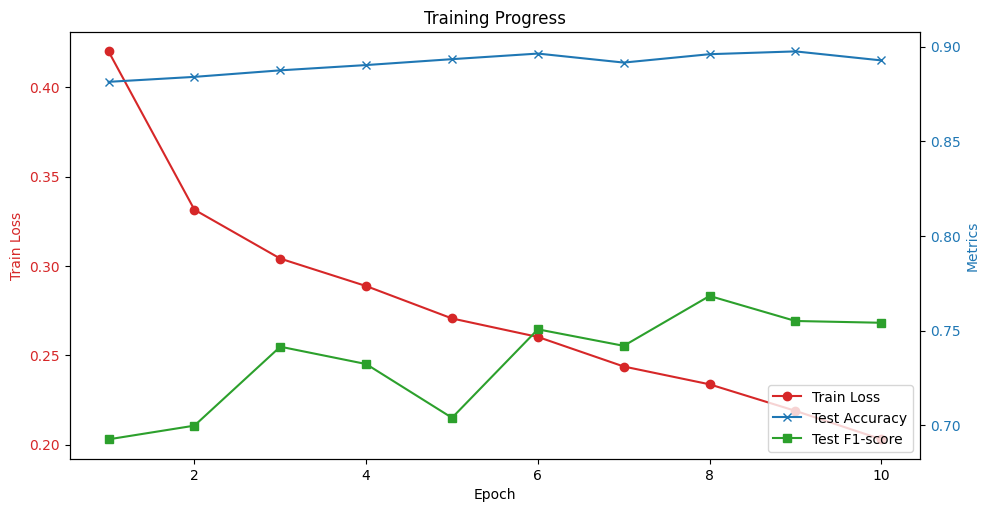

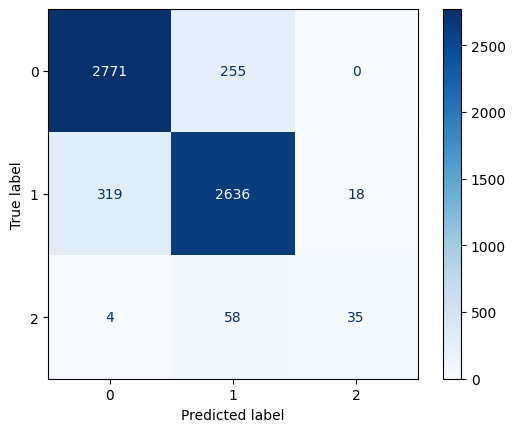


Final Results:
Accuracy: 0.8927
Macro-F1: 0.7542
CNN Train Accuracy: 0.8927165354330708
CNN Train Macro-F1: 0.7541540020263424


In [44]:
cnn_acc, cnn_f1, cnn_cm = train_model(model, train_loader, test_loader, epochs=10, lr=1e-3)
print("CNN Train Accuracy:", cnn_acc)
print("CNN Train Macro-F1:", cnn_f1)

Evaluating: 100%|████████████████████████████| 191/191 [00:00<00:00, 621.07it/s]

Test Loss = 0.3123, Test Accuracy = 0.8927, Test F1 = 0.7542


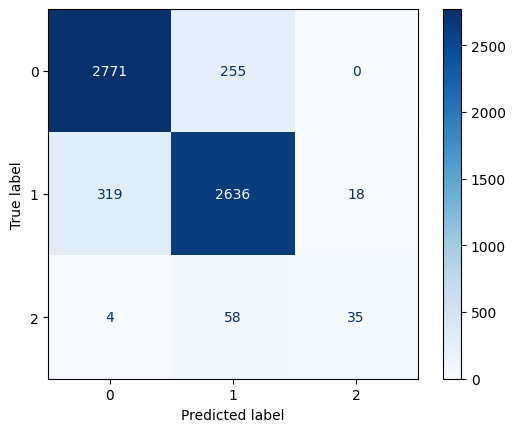

CNN Test Accuracy: 0.8927165354330708
CNN Test Macro-F1: 0.7541540020263424


In [45]:
test_acc, test_f1, test_cm = evaluate(model, test_loader)
print("CNN Test Accuracy:", test_acc)
print("CNN Test Macro-F1:", test_f1)

**Метрики очень близки к 90%, но возможно для контекстуальных задач RNN с hidden слоями продемонстрируют себя лучшим образом**

**Попробуем двунаправленную RNN, чтобы лучше схватывать контекст. Здесь предварительно заметим, чтобы для лучшей перфомативности мы взяли не только выход последнего hidden слоя, поскольку в таком случае метрики были неудовлетворительными, а выходы со всех hidden слоев и затем пропускаем их через пуллинг. Так удалось качественно повысить метрики.**

**Сначала попробуем LSTM слои**

In [48]:
class BiLSTM_FT(nn.Module):
    def __init__(self, embed_dim=300, hidden_size=128, num_layers=2, num_classes=3, dropout=0.5):
        super().__init__()
        self.lstm = nn.LSTM(embed_dim, hidden_size, num_layers=num_layers, 
                            bidirectional=True, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        out, (h, c) = self.lstm(x)  # out: [B, L, hidden_size*2]
        x = torch.max(out, dim=1)[0]  # Max pooling по длине: [B, hidden_size*2]
        x = self.dropout(x)
        return self.fc(x)

model_lstm = BiLSTM_FT(embed_dim=300, hidden_size=128, num_layers=2, num_classes=len(set(y_train)))
print(model_lstm)

BiLSTM_FT(
  (lstm): LSTM(300, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)


In [ ]:
lstm_acc, lstm_f1, lstm_cm = train_model(model_lstm, train_loader, test_loader, epochs=10, lr=1e-3)
print("BiLSTM Train Accuracy:", lstm_acc)
print("BiLSTM Train Macro-F1:", lstm_f1)

test_acc, test_cm = evaluate(model_lstm, test_loader)
print("BiLSTM Test Accuracy:", test_acc)

**Как видно, LSTM отрабатывает несколько лучше, чем CNN. Получили метрику > 90%**

**Попробуем использовать GRU слои. Они "проще", но часто GRU отрабатывают лучше LSTM, вероятно, поскольку меньше запоминают шумовых данных, они более оптимизированные**

In [50]:
class BiGRU_FT(nn.Module):
    def __init__(self, embed_dim=300, hidden_size=128, num_layers=2, num_classes=3, dropout=0.5):
        super().__init__()
        self.gru = nn.GRU(embed_dim, hidden_size, num_layers=num_layers, 
                          bidirectional=True, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.attention = nn.Linear(hidden_size * 2, 1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        out, h = self.gru(x)  # out: [B, L, hidden_size*2]
        attn_weights = F.softmax(self.attention(out), dim=1)  # [B, L, 1]
        x = torch.sum(out * attn_weights, dim=1)  # [B, hidden_size*2]
        x = self.dropout(x)
        return self.fc(x)
        
model_gru = BiGRU_FT(embed_dim=300, hidden_size=128, num_layers=2, num_classes=len(set(y_train)))
print(model_gru)

BiGRU_FT(
  (gru): GRU(300, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (attention): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)


Epoch 1/10: 100%|█████████████████| 750/750 [00:03<00:00, 212.62it/s, loss=0.18]


Epoch 1: Train Loss = 0.3548, Test Accuracy = 0.9003


Epoch 2/10: 100%|█████████████████| 750/750 [00:03<00:00, 216.08it/s, loss=0.35]


Epoch 2: Train Loss = 0.2640, Test Accuracy = 0.9017


Epoch 3/10: 100%|████████████████| 750/750 [00:03<00:00, 220.08it/s, loss=0.294]


Epoch 3: Train Loss = 0.2435, Test Accuracy = 0.9067


Epoch 4/10: 100%|████████████████| 750/750 [00:03<00:00, 217.92it/s, loss=0.218]


Epoch 4: Train Loss = 0.2287, Test Accuracy = 0.8991


Epoch 5/10: 100%|████████████████| 750/750 [00:03<00:00, 218.72it/s, loss=0.174]


Epoch 5: Train Loss = 0.2179, Test Accuracy = 0.9094


Epoch 6/10: 100%|████████████████| 750/750 [00:03<00:00, 221.51it/s, loss=0.264]


Epoch 6: Train Loss = 0.2059, Test Accuracy = 0.9042


Epoch 7/10: 100%|████████████████| 750/750 [00:03<00:00, 220.09it/s, loss=0.121]


Epoch 7: Train Loss = 0.1927, Test Accuracy = 0.9055


Epoch 8/10: 100%|████████████████| 750/750 [00:03<00:00, 218.88it/s, loss=0.258]


Epoch 8: Train Loss = 0.1776, Test Accuracy = 0.8980


Epoch 9/10: 100%|████████████████| 750/750 [00:03<00:00, 220.36it/s, loss=0.137]


Epoch 9: Train Loss = 0.1635, Test Accuracy = 0.9011


Epoch 10/10: 100%|███████████████| 750/750 [00:03<00:00, 220.94it/s, loss=0.388]


Epoch 10: Train Loss = 0.1445, Test Accuracy = 0.9029


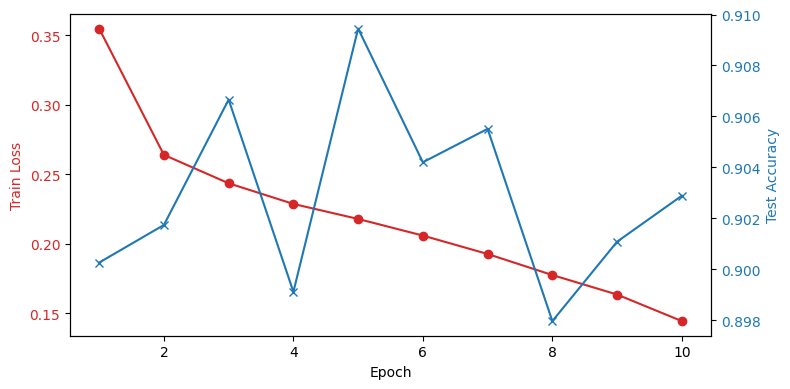

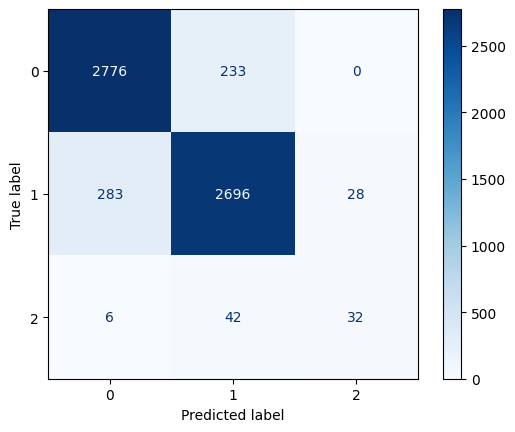

BiGRU Train Accuracy: 0.9028871391076115


In [51]:
# === Запуск обучения и оценки для GRU ===
gru_acc, gru_f1, gru_cm = train_model(model_gru, train_loader, test_loader, epochs=10, lr=1e-3)
print("BiGRU Train Accuracy:", gru_acc)
print("BiGRU Train Macro-F1:", gru_f1)

Evaluating: 100%|████████████████████████████| 191/191 [00:00<00:00, 505.25it/s]


Test Loss = 0.2792, Test Accuracy = 0.9029


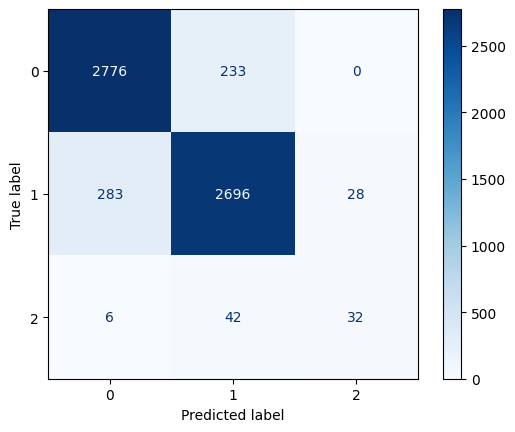

BiGRU Test Accuracy: 0.9028871391076115


In [52]:
test_acc, test_f1, test_cm = evaluate(model_gru, test_loader)
print("BiGRU Test Accuracy:", test_acc)
print("BiGRU Test Macro-F1:", test_f1)

**Метрики, как минимум, не хуже, и также превышают 90%**

**Russian language models**

**Попробуем натренировать модели на русскоязычных датасетах и посмотреть метрики**

**Далее будут использоваться те же функции и те же архитектуры, поэтому мотивировка использования тех или иных методов идентична и не дублируется**

In [8]:
import random
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
import fasttext.util
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import pandas as pd
import re

In [14]:
dataset = pd.read_csv('rus_toxic_full_df.csv')
dataset


,text,neutral,toxic_threat,toxic_not_threat
0,скотина! что сказать,0,0,1
1,я сегодня проезжала по рабочей и между домами ...,1,0,0
2,очередной лохотрон. зачем придумывать очередно...,1,0,0
3,"ретро дежавю ... сложно понять чужое сердце , ...",1,0,0
4,а когда мы статус агрогородка получили?,1,0,0
...,...,...,...,...
248285,правильно всё по пять (5)...,1,0,0
248286,ёбанные нубы заходите на сервер мой ник _creep...,0,0,1
248287,а у меня наверное рекорд в 1962 году в училище...,1,0,0
248288,спасибо всем большое),1,0,0


In [16]:
x = dataset['text']
y = dataset[['neutral', 'toxic_not_threat', 'toxic_threat']]

print(y['neutral'].value_counts())
print(y['toxic_not_threat'].value_counts())
print(y['toxic_threat'].value_counts())


neutral
1    203685
0     44605
Name: count, dtype: int64
toxic_not_threat
0    215712
1     32578
Name: count, dtype: int64
toxic_threat
0    236263
1     12027
Name: count, dtype: int64


In [18]:

# 1. Полнота данных
def data_completeness(df):
    total_cells = df.size
    missing_cells = df.isnull().sum().sum()
    completeness = ((total_cells - missing_cells) / total_cells) * 100
    return completeness

# 2. Лексическое разнообразие
def lexical_diversity(text):
    if pd.isna(text) or text == '':
        return 0
    words = text.lower().split()
    if len(words) == 0:
        return 0
    return len(set(words)) / len(words)

# 3. Уровень читаемости
def readability_score(text):
    if pd.isna(text) or text == '':
        return 0
    try:
        return flesch_reading_ease(text)
    except:
        return 0

# 4. Структурная целостность
def structural_integrity(text):
    if pd.isna(text) or text == '':
        return 0
    
    # Проверяем наличие пунктуации и структуры
    has_punctuation = any(char in text for char in ['.', '!', '?'])
    has_capitalization = any(char.isupper() for char in text)
    word_count = len(text.split())
    
    score = 0
    if has_punctuation: score += 0.3
    if has_capitalization: score += 0.3
    if word_count >= 3: score += 0.4
    
    return score

# 5. Отсутствие шума
def noise_level(text):
    if pd.isna(text) or text == '':
        return 1  # Пустой текст считается чистым
    
    # Ищем признаки шума: повторяющиеся символы, капс и т.д.
    noise_indicators = 0
    
    # Повторяющиеся символы (более 3 подряд)
    if re.search(r'(.)\1{3,}', text):
        noise_indicators += 1
    
    # Чрезмерное использование заглавных букв
    if len(text) > 10:
        upper_ratio = sum(1 for char in text if char.isupper()) / len(text)
        if upper_ratio > 0.5:
            noise_indicators += 1
    
    # Слишком короткие или длинные слова
    words = text.split()
    if words:
        unusual_words = sum(1 for word in words if len(word) > 20 or len(word) == 1)
        if unusual_words / len(words) > 0.3:
            noise_indicators += 1
    
    return 1 - (noise_indicators / 3)

# 6. Лингвистическая корректность (упрощенная версия)
def linguistic_correctness(text):
    if pd.isna(text) or text == '':
        return 0
    
    try:
        # Простая проверка на английские слова
        english_words = set(words.words())
        text_words = re.findall(r'\b[a-zA-Z]+\b', text.lower())
        
        if not text_words:
            return 0
        
        # Процент слов, которые есть в английском словаре
        valid_words = sum(1 for word in text_words if word in english_words)
        return valid_words / len(text_words)
    except:
        return 0.5  # Среднее значение при ошибке

# Функция для определения уровня качества
def get_quality_level(score):
    if score >= 90:
        return "отличный"
    elif score >= 80:
        return "хороший"
    elif score >= 70:
        return "средний"
    elif score >= 60:
        return "удовлетворительный"
    else:
        return "низкий"

# Вычисление метрик для всего датасета
print("=== АНАЛИЗ ДАТАСЕТА ===")
print(f"Всего записей: {len(dataset)}")

# Полнота данных
completeness = data_completeness(dataset)
print(f"\n1. Полнота данных: {completeness:.2f}%")

# Лексическое разнообразие (только для текстовых колонок)
lex_div = dataset['text'].apply(lexical_diversity).mean()
print(f"2. Среднее лексическое разнообразие: {lex_div:.3f}")

# Уровень читаемости
readability = dataset['text'].apply(readability_score).mean()
print(f"3. Средний уровень читаемости: {readability:.2f}")

# Структурная целостность
structure = dataset['text'].apply(structural_integrity).mean()
print(f"4. Средняя структурная целостность: {structure:.3f}")

# Отсутствие шума
noise_free = dataset['text'].apply(noise_level).mean()
print(f"5. Средний уровень отсутствия шума: {noise_free:.3f}")

# Лингвистическая корректность
linguistic = dataset['text'].apply(linguistic_correctness).mean()
print(f"6. Средняя лингвистическая корректность: {linguistic:.3f}")

# Дополнительная статистика
print(f"\n=== ДОПОЛНИТЕЛЬНАЯ СТАТИСТИКА ===")
print(f"Средняя длина комментария: {dataset['text'].str.len().mean():.1f} символов")
print(f"Среднее количество слов: {dataset['text'].str.split().str.len().mean():.1f}")

# Расчет итоговой оценки качества данных
print(f"\n=== ИТОГОВАЯ ОЦЕНКА КАЧЕСТВА ДАННЫХ ===")

# Нормализуем показатели к шкале 0-100
metrics = {
    "Полнота данных": completeness,  # уже в процентах
    "Лексическое разнообразие": lex_div * 100,  # из 0-1 в 0-100
    "Уровень читаемости": min(readability, 100),  # ограничиваем максимум 100
    "Структурная целостность": structure * 100,  # из 0-1 в 0-100
    "Отсутствие шума": noise_free * 100,  # из 0-1 в 0-100
    "Лингвистическая корректность": linguistic * 100  # из 0-1 в 0-100
}

# Выводим нормализованные показатели
print("\nНормализованные показатели (0-100):")
for metric, value in metrics.items():
    print(f"  {metric}: {value:.1f}")

# Взвешенная итоговая оценка (можно настроить веса)
weights = {
    "Полнота данных": 0.15,  # самый важный показатель
    "Лексическое разнообразие": 0.15,
    "Уровень читаемости": 0.20,
    "Структурная целостность": 0.15,
    "Отсутствие шума": 0.15,
    "Лингвистическая корректность": 0.20
}

# Расчет итоговой оценки
total_score = sum(metrics[metric] * weight for metric, weight in weights.items())
quality_level = get_quality_level(total_score)

print(f"\n ОБЩАЯ ОЦЕНКА КАЧЕСТВА ДАННЫХ - {total_score:.1f} из 100 баллов, "
      f"что соответствует {quality_level} уровню.")



=== АНАЛИЗ ДАТАСЕТА ===
Всего записей: 248290

1. Полнота данных: 100.00%
2. Среднее лексическое разнообразие: 0.971
3. Средний уровень читаемости: 113.80
4. Средняя структурная целостность: 0.563
5. Средний уровень отсутствия шума: 0.950
6. Средняя лингвистическая корректность: 0.500

=== ДОПОЛНИТЕЛЬНАЯ СТАТИСТИКА ===
Средняя длина комментария: 78.1 символов
Среднее количество слов: 12.5

=== ИТОГОВАЯ ОЦЕНКА КАЧЕСТВА ДАННЫХ ===

Нормализованные показатели (0-100):
  Полнота данных: 100.0
  Лексическое разнообразие: 97.1
  Уровень читаемости: 100.0
  Структурная целостность: 56.3
  Отсутствие шума: 95.0
  Лингвистическая корректность: 50.0

 ОБЩАЯ ОЦЕНКА КАЧЕСТВА ДАННЫХ - 82.3 из 100 баллов, что соответствует хороший уровню.


**Здесь датасет довольно сбалансированный, можно взять по 12 000 примеров на каждый класс**

In [124]:
neutral_df = dataset[dataset['neutral'] == 1].sample(n=12000)
toxic_not_threat_df = dataset[dataset['toxic_not_threat'] == 1].sample(n=12000)
toxic_threat_df = dataset[dataset['toxic_threat'] == 1].sample(n=12000)
balanced_dataset = pd.concat([neutral_df, toxic_not_threat_df, toxic_threat_df], axis=0)
balanced_dataset = balanced_dataset.sample(frac=1, random_state=42).reset_index(drop=True)
balanced_dataset

,text,neutral,toxic_threat,toxic_not_threat
0,такую резонансную точку и я могу поставить на ...,0,0,1
1,тварина натравливает чурбан белорусских мусоро...,0,0,1
2,"идиоты,полные,привязать самих , и оставить,про...",0,0,1
3,этого козла самого бы за яйца привезать верёвк...,0,1,0
4,когда уже откроется новая полянка? я в этот кв...,1,0,0
...,...,...,...,...
35995,"да их хоть ебать можно, а с обезьянами что делать",0,0,1
35996,коты они и у людей перенимают манеру поведения...,1,0,0
35997,шикарный бант на ободке. можно использовать не...,1,0,0
35998,это не ручная работа. очередной фэйк.,1,0,0


In [126]:
x = balanced_dataset['text']
y = balanced_dataset[['neutral', 'toxic_not_threat', 'toxic_threat']]
print(y['neutral'].value_counts())
print(y['toxic_not_threat'].value_counts())
print(y['toxic_threat'].value_counts())

neutral
0    24000
1    12000
Name: count, dtype: int64
toxic_not_threat
0    24000
1    12000
Name: count, dtype: int64
toxic_threat
0    24000
1    12000
Name: count, dtype: int64


In [128]:
y

,neutral,toxic_not_threat,toxic_threat
0,0,1,0
1,0,1,0
2,0,1,0
3,0,0,1
4,1,0,0
...,...,...,...
35995,0,1,0
35996,1,0,0
35997,1,0,0
35998,1,0,0


In [130]:
y = y.idxmax(axis=1).map({'neutral': 0, 'toxic_not_threat': 1, 'toxic_threat': 2}).values
print("labels shape:", y.shape)
print("Пример меток:", y[:5])

labels shape: (36000,)
Пример меток: [1 1 1 2 0]


**Делим трейн и тест пополам, чтобы тестовая выборка была репрезентативной, в данном случае это 18000 примеров на тест**

In [135]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, shuffle=True)


In [137]:
x_train

30546                       вот сука,ноги надо ей поломать
13092    госдума предлагает лишать гражданства тех выбо...
27898    бейте их при попытке к бегству. они знают на ч...
5521     ну правильно где вы видели,что бы в концлагеря...
703                           есть кто в люберцах кто едит
                               ...                        
9515                  а я выращиваю сама ну очень вкусные!
3452                                     а почём помидоры?
4611     зачем сожать ищё в терме надо их кормить , сра...
6163                                 пидороси кто нописоль
34490                                  ты тоже бляд нацист
Name: text, Length: 18000, dtype: object

**Здесь мы вынуждены разбивать на чанки без из подачи в итеративную функцию, т.к. любой итератор зависает. Таким образом, будем трансформировать каждый чанк в эбеддинги через отдельный запуск**

In [139]:
x_1 = x_train[:2000]
x_2 = x_train[2000:4000]
x_3 = x_train[4000:6000]
x_4 = x_train[6000:8000]
x_5 = x_train[8000:10000]
x_6 = x_train[10000:12000]
x_7 = x_train[12000:14000]
x_8 = x_train[14000:16000]
x_9 = x_train[16000:18000]

In [141]:
x_9

11356    в тюряге там его кончают. я предлогаю сразу рс...
9720     аще! охуе... ю! народы украины и белоруссии, к...
14189    я тебе тогда прочитаю дедушка с бабушкой очень...
25359    так она как блоха скачит с хрена на хрен и все...
20312     навральный чмо лпущенное. ему россияне не верят.
                               ...                        
9515                  а я выращиваю сама ну очень вкусные!
3452                                     а почём помидоры?
4611     зачем сожать ищё в терме надо их кормить , сра...
6163                                 пидороси кто нописоль
34490                                  ты тоже бляд нацист
Name: text, Length: 2000, dtype: object

**Далее проводим предобработку данных и преобразуем наши данные в эмбеддинги**

In [146]:
# === FastText ===
print("\n=== FastText ===")
fasttext.util.download_model('ru', if_exists='ignore')
ft = fasttext.load_model('cc.ru.300.bin')

def get_text_embedding(text, model, max_len=50):
    text = text.lower()
    text = re.sub(r"[^а-яёa-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    words = text.strip().split()[:max_len]
    word_vectors = [model.get_word_vector(w) for w in words if w]
    if len(word_vectors) == 0:
        return np.zeros((max_len, model.get_dimension()))  # [max_len, 300]
    word_vectors = np.array(word_vectors)  # [len(words), 300]
    pad_len = max_len - len(word_vectors)
    word_vectors = np.pad(word_vectors, ((0, pad_len), (0, 0)), mode='constant')  # [max_len, 300]
    return word_vectors


=== FastText ===


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [13]:
X_train_ft_1 = np.array([get_text_embedding(s, ft) for s in x_1])

In [14]:
X_train_ft_2 = np.array([get_text_embedding(s, ft) for s in x_2])

In [15]:
X_train_ft_3 = np.array([get_text_embedding(s, ft) for s in x_3])

In [16]:
X_train_ft_4 = np.array([get_text_embedding(s, ft) for s in x_4])

In [17]:
X_train_ft_5 = np.array([get_text_embedding(s, ft) for s in x_5])

In [18]:
X_train_ft_6 = np.array([get_text_embedding(s, ft) for s in x_6])

In [19]:
X_train_ft_7 = np.array([get_text_embedding(s, ft) for s in x_7])

In [20]:
X_train_ft_8 = np.array([get_text_embedding(s, ft) for s in x_8])

In [21]:
X_train_ft_9 = np.array([get_text_embedding(s, ft) for s in x_9])

In [22]:
print([get_text_embedding(s, ft).shape for s in x_9[:5]])

[(50, 300), (50, 300), (50, 300), (50, 300), (50, 300)]


In [23]:
X_train_ft = np.concatenate(
    [X_train_ft_1, X_train_ft_2, X_train_ft_3, X_train_ft_4, 
     X_train_ft_5, X_train_ft_6, X_train_ft_7, X_train_ft_8, 
     X_train_ft_9],
    axis=0
)

In [24]:
X_train_ft

array([[[ 2.13465490e-03, -3.14592011e-03, -9.29429103e-03, ...,
         -1.94670446e-02,  3.40633057e-02, -3.30008939e-03],
        [ 5.17563708e-02,  9.47899558e-03,  2.02253647e-02, ...,
          2.75836121e-02, -5.26788048e-02, -3.58344205e-02],
        [ 1.53560471e-02, -4.27011475e-02, -1.04131699e-02, ...,
         -4.96229902e-02, -6.60395771e-02, -1.99417874e-01],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 1.29841775e-01, -6.50196522e-03, -7.11609945e-02, ...,
         -4.42091897e-02, -2.45059550e-01, -8.00090730e-02],
        [ 2.05443315e-02, -1.71633363e-01, -7.19676018e-02, ...,
          2.53604688e-02, -6.78354502e

In [25]:
X_test_ft = np.array([get_text_embedding(s, ft) for s in x_test])    # [M, max_len, 300]
print(X_train_ft[0][:10, :10])  # Первые 10 слов, первые 10 элементов

Пример эмбеддинга FastText для первого текста: [[ 0.00213465 -0.00314592 -0.00929429  0.0334738   0.0228604   0.04059345
  -0.00528134 -0.03792536 -0.04602993 -0.00695037]
 [ 0.05175637  0.009479    0.02022536  0.01808274  0.0296282   0.00295898
   0.01422787 -0.02266838 -0.01581611  0.01027999]
 [ 0.01535605 -0.04270115 -0.01041317  0.10524878 -0.03188214 -0.08835521
  -0.04817184  0.08577232 -0.05629525 -0.05624069]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.   

In [26]:
# === TextDataset ===
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)  # [N, max_len, 300]
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 32
train_dataset = TextDataset(X_train_ft, y_train)

In [27]:
test_dataset = TextDataset(X_test_ft, y_test)

In [28]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [29]:
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [30]:
# === TextCNN_FT ===
class TextCNN_FT(nn.Module):
    def __init__(self, embed_dim=300, num_classes=3, kernel_sizes=[3,4,5], num_filters=100, dropout=0.5):
        super().__init__()
        self.convs = nn.ModuleList([nn.Conv1d(embed_dim, num_filters, k) for k in kernel_sizes])
        self.dropout = nn.Dropout(dropout)
        self.bn = nn.BatchNorm1d(num_filters * len(kernel_sizes) * 2)  # *2 для max+avg pooling
        self.fc = nn.Linear(num_filters * len(kernel_sizes) * 2, num_classes)

    def forward(self, x):
        # x: [B, L, E]
        x = x.permute(0, 2, 1)  # [B, E, L]
        convs = [F.relu(conv(x)) for conv in self.convs]  # [B, F, L-k+1]
        pools_max = [F.max_pool1d(c, c.size(2)).squeeze(2) for c in convs]  # [B, F]
        pools_avg = [F.avg_pool1d(c, c.size(2)).squeeze(2) for c in convs]  # [B, F]
        pools = [torch.cat([pm, pa], dim=1) for pm, pa in zip(pools_max, pools_avg)]  # [B, 2F]
        x = torch.cat(pools, dim=1)  # [B, 2F * len(kernel_sizes)]
        x = self.dropout(self.bn(x))
        return self.fc(x)

In [31]:
model = TextCNN_FT(embed_dim=300, num_classes=3)
print(model)

TextCNN_FT(
  (convs): ModuleList(
    (0): Conv1d(300, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(300, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(300, 100, kernel_size=(5,), stride=(1,))
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (bn): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=600, out_features=3, bias=True)
)


In [ ]:
# === Функция обучения ===
def train_model(model, train_loader, test_loader, epochs=5, lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    train_losses = []
    test_accuracies = []
    test_f1_scores = []  # Добавляем список для F1-score
    
    for epoch in range(1, epochs+1):
        model.train()
        running_loss = 0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}")
        
        for X_batch, y_batch in pbar:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # [B, max_len, 300], [B]
            optimizer.zero_grad()
            logits = model(X_batch)  # [B, num_classes]
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * X_batch.size(0)
            pbar.set_postfix({"loss": loss.item()})
        
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        
        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                logits = model(X_batch)
                preds = torch.argmax(logits, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(y_batch.cpu().numpy())
        
        acc = accuracy_score(all_labels, all_preds)
        test_accuracies.append(acc)
        
        # Добавляем подсчет Macro-F1
        f1 = f1_score(all_labels, all_preds, average='macro')
        test_f1_scores.append(f1)
        
        print(f"Epoch {epoch}: Train Loss = {epoch_loss:.4f}, Test Accuracy = {acc:.4f}, Test F1 = {f1:.4f}")
    
    # График Loss, Accuracy и F1-score
    fig, ax1 = plt.subplots(figsize=(10,5))
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Train Loss', color='tab:red')
    ax1.plot(range(1, epochs+1), train_losses, color='tab:red', marker='o', label='Train Loss')
    ax1.tick_params(axis='y', labelcolor='tab:red')
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('Metrics', color='tab:blue')
    ax2.plot(range(1, epochs+1), test_accuracies, color='tab:blue', marker='x', label='Test Accuracy')
    ax2.plot(range(1, epochs+1), test_f1_scores, color='tab:green', marker='s', label='Test F1-score')
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    
    # Добавляем легенду
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='best')
    
    fig.tight_layout()
    plt.title('Training Progress')
    plt.show()
    
    # Confusion Matrix
    final_cm = confusion_matrix(all_labels, all_preds)
    ConfusionMatrixDisplay(final_cm).plot(cmap="Blues")
    plt.show()
    
    # Выводим финальные метрики
    final_accuracy = test_accuracies[-1]
    final_f1 = test_f1_scores[-1]
    print(f"\nFinal Results:")
    print(f"Accuracy: {final_accuracy:.4f}")
    print(f"Macro-F1: {final_f1:.4f}")
    
    return test_accuracies[-1], test_f1_scores[-1], final_cm

In [33]:
def evaluate(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    all_preds = []
    all_labels = []
    running_loss = 0
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for X_batch, y_batch in tqdm(test_loader, desc="Evaluating"):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # [B, max_len, 300], [B]
            logits = model(X_batch)  # [B, num_classes]
            loss = criterion(logits, y_batch)
            running_loss += loss.item() * X_batch.size(0)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    
    test_loss = running_loss / len(test_loader.dataset)
    test_accuracy = accuracy_score(all_labels, all_preds)
    # Вычисление Macro-F1
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    
    print(f"Test Loss = {test_loss:.4f}, Test Accuracy = {test_accuracy:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    ConfusionMatrixDisplay(cm).plot(cmap="Blues")
    plt.show()
    
    return test_accuracy, macro_f1, cm

Epoch 1/10: 100%|████████████████| 563/563 [00:02<00:00, 240.45it/s, loss=0.399]


Epoch 1: Train Loss = 0.5164, Test Accuracy = 0.8479


Epoch 2/10: 100%|████████████████| 563/563 [00:01<00:00, 309.17it/s, loss=0.511]


Epoch 2: Train Loss = 0.3605, Test Accuracy = 0.8869


Epoch 3/10: 100%|█████████████████| 563/563 [00:01<00:00, 326.14it/s, loss=0.41]


Epoch 3: Train Loss = 0.3155, Test Accuracy = 0.8735


Epoch 4/10: 100%|████████████████| 563/563 [00:01<00:00, 332.44it/s, loss=0.205]


Epoch 4: Train Loss = 0.2865, Test Accuracy = 0.8936


Epoch 5/10: 100%|████████████████| 563/563 [00:01<00:00, 310.53it/s, loss=0.127]


Epoch 5: Train Loss = 0.2533, Test Accuracy = 0.8931


Epoch 6/10: 100%|████████████████| 563/563 [00:01<00:00, 333.41it/s, loss=0.464]


Epoch 6: Train Loss = 0.2351, Test Accuracy = 0.8921


Epoch 7/10: 100%|████████████████| 563/563 [00:01<00:00, 321.57it/s, loss=0.199]


Epoch 7: Train Loss = 0.2108, Test Accuracy = 0.8913


Epoch 8/10: 100%|████████████████| 563/563 [00:01<00:00, 319.75it/s, loss=0.248]


Epoch 8: Train Loss = 0.1945, Test Accuracy = 0.8952


Epoch 9/10: 100%|████████████████| 563/563 [00:01<00:00, 326.74it/s, loss=0.419]


Epoch 9: Train Loss = 0.1831, Test Accuracy = 0.8969


Epoch 10/10: 100%|███████████████| 563/563 [00:01<00:00, 340.58it/s, loss=0.137]


Epoch 10: Train Loss = 0.1684, Test Accuracy = 0.8917


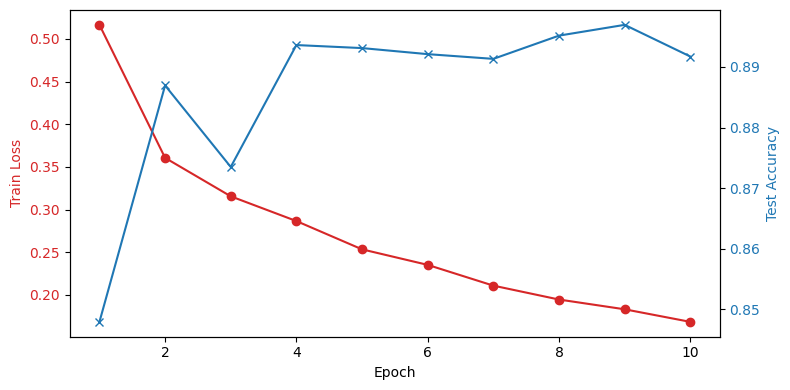

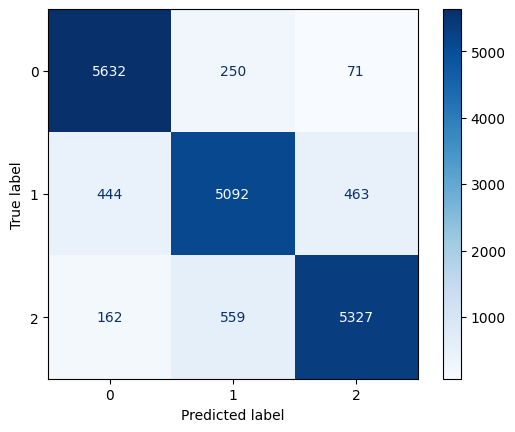

CNN Train Accuracy: 0.8917222222222222


In [34]:
cnn_acc, cnn_f1, cnn_cm = train_model(model, train_loader, test_loader, epochs=10, lr=1e-3)
print(f"CNN Train Accuracy: {cnn_acc:.4f}, Macro-F1: {cnn_f1:.4f}")

Evaluating: 100%|████████████████████████████| 563/563 [00:00<00:00, 705.38it/s]


Test Loss = 0.3464, Test Accuracy = 0.8917


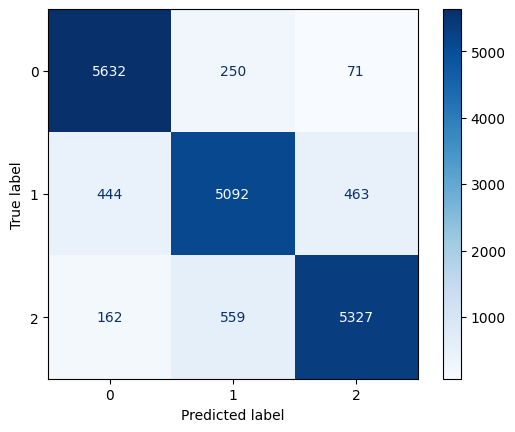

CNN Test Accuracy: 0.8917222222222222


In [35]:
test_acc, test_f1, test_cm = evaluate(model, test_loader)
print("CNN Test Accuracy:", test_acc)
print("CNN Test Macro-F1:", test_f1)

Epoch 1/10: 100%|████████████████| 563/563 [00:03<00:00, 181.09it/s, loss=0.815]


Epoch 1: Train Loss = 0.5364, Test Accuracy = 0.8721


Epoch 2/10: 100%|████████████████| 563/563 [00:03<00:00, 185.16it/s, loss=0.307]


Epoch 2: Train Loss = 0.3173, Test Accuracy = 0.8918


Epoch 3/10: 100%|█████████████████| 563/563 [00:03<00:00, 183.08it/s, loss=0.35]


Epoch 3: Train Loss = 0.2735, Test Accuracy = 0.8998


Epoch 4/10: 100%|███████████████| 563/563 [00:03<00:00, 185.02it/s, loss=0.0945]


Epoch 4: Train Loss = 0.2420, Test Accuracy = 0.9040


Epoch 5/10: 100%|█████████████████| 563/563 [00:03<00:00, 184.38it/s, loss=0.34]


Epoch 5: Train Loss = 0.2175, Test Accuracy = 0.9015


Epoch 6/10: 100%|████████████████| 563/563 [00:03<00:00, 183.00it/s, loss=0.049]


Epoch 6: Train Loss = 0.2003, Test Accuracy = 0.9087


Epoch 7/10: 100%|███████████████| 563/563 [00:03<00:00, 184.29it/s, loss=0.0752]


Epoch 7: Train Loss = 0.1827, Test Accuracy = 0.9069


Epoch 8/10: 100%|███████████████| 563/563 [00:03<00:00, 184.26it/s, loss=0.0338]


Epoch 8: Train Loss = 0.1661, Test Accuracy = 0.9101


Epoch 9/10: 100%|████████████████| 563/563 [00:03<00:00, 185.17it/s, loss=0.109]


Epoch 9: Train Loss = 0.1506, Test Accuracy = 0.9091


Epoch 10/10: 100%|██████████████| 563/563 [00:03<00:00, 184.79it/s, loss=0.0615]


Epoch 10: Train Loss = 0.1346, Test Accuracy = 0.9100


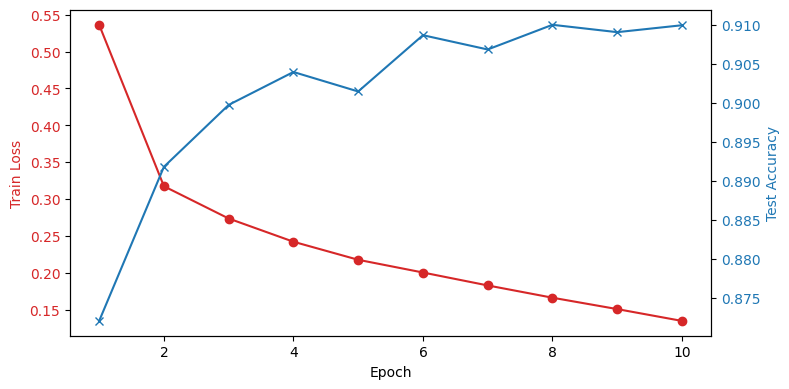

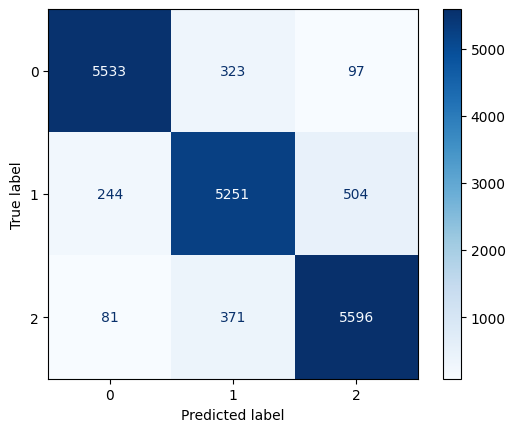

BiLSTM Train Accuracy: 0.91


In [39]:
lstm_acc, lstm_f1, lstm_cm = train_model(model_lstm, train_loader, test_loader, epochs=10, lr=1e-3)
print("BiLSTM Train Accuracy:", lstm_acc)
print("BiLSTM Train Macro-F1:", lstm_f1)

Evaluating: 100%|████████████████████████████| 563/563 [00:01<00:00, 415.88it/s]

Test Loss = 0.2838, Test Accuracy = 0.9100


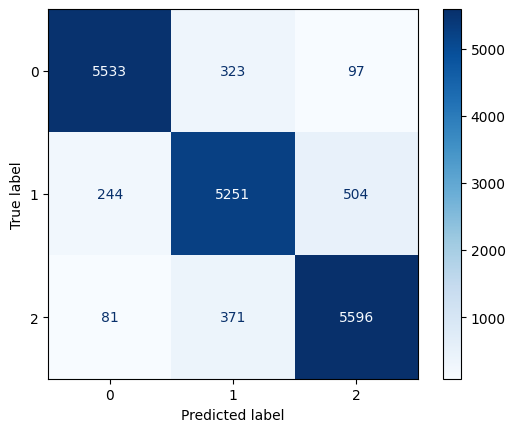

BiLSTM Test Accuracy: 0.91


In [40]:
test_acc, test_f1, test_cm = evaluate(model_lstm, test_loader)
print("BiLSTM Test Accuracy:", test_acc)
print("BiLSTM Test Macro-F1:", test_f1)

**Таким образом, удалось достигнуть отметки accuracy > 90%**

Epoch 1/20: 100%|████████████████| 563/563 [00:02<00:00, 199.82it/s, loss=0.275]


Epoch 1: Train Loss = 0.4738, Test Accuracy = 0.8849


Epoch 2/20: 100%|████████████████| 563/563 [00:02<00:00, 221.75it/s, loss=0.416]


Epoch 2: Train Loss = 0.2797, Test Accuracy = 0.9002


Epoch 3/20: 100%|███████████████| 563/563 [00:02<00:00, 222.08it/s, loss=0.0887]


Epoch 3: Train Loss = 0.2421, Test Accuracy = 0.9076


Epoch 4/20: 100%|████████████████| 563/563 [00:02<00:00, 217.84it/s, loss=0.293]


Epoch 4: Train Loss = 0.2178, Test Accuracy = 0.9099


Epoch 5/20: 100%|████████████████| 563/563 [00:02<00:00, 219.40it/s, loss=0.273]


Epoch 5: Train Loss = 0.2036, Test Accuracy = 0.9106


Epoch 6/20: 100%|████████████████| 563/563 [00:02<00:00, 216.87it/s, loss=0.318]


Epoch 6: Train Loss = 0.1849, Test Accuracy = 0.9130


Epoch 7/20: 100%|███████████████| 563/563 [00:02<00:00, 216.75it/s, loss=0.0503]


Epoch 7: Train Loss = 0.1695, Test Accuracy = 0.9145


Epoch 8/20: 100%|████████████████| 563/563 [00:02<00:00, 217.68it/s, loss=0.278]


Epoch 8: Train Loss = 0.1562, Test Accuracy = 0.9109


Epoch 9/20: 100%|█████████████████| 563/563 [00:02<00:00, 218.52it/s, loss=0.66]


Epoch 9: Train Loss = 0.1352, Test Accuracy = 0.9095


Epoch 10/20: 100%|███████████████| 563/563 [00:02<00:00, 218.19it/s, loss=0.273]


Epoch 10: Train Loss = 0.1244, Test Accuracy = 0.9075


Epoch 11/20: 100%|███████████████| 563/563 [00:02<00:00, 212.90it/s, loss=0.132]


Epoch 11: Train Loss = 0.1057, Test Accuracy = 0.9129


Epoch 12/20: 100%|██████████████| 563/563 [00:02<00:00, 216.22it/s, loss=0.0129]


Epoch 12: Train Loss = 0.0926, Test Accuracy = 0.9081


Epoch 13/20: 100%|█████████████| 563/563 [00:02<00:00, 217.78it/s, loss=0.00432]


Epoch 13: Train Loss = 0.0802, Test Accuracy = 0.9088


Epoch 14/20: 100%|██████████████| 563/563 [00:02<00:00, 217.33it/s, loss=0.0245]


Epoch 14: Train Loss = 0.0716, Test Accuracy = 0.9045


Epoch 15/20: 100%|███████████████| 563/563 [00:02<00:00, 217.03it/s, loss=0.276]


Epoch 15: Train Loss = 0.0632, Test Accuracy = 0.9067


Epoch 16/20: 100%|███████████████| 563/563 [00:02<00:00, 215.85it/s, loss=0.489]


Epoch 16: Train Loss = 0.0559, Test Accuracy = 0.9069


Epoch 17/20: 100%|█████████████| 563/563 [00:02<00:00, 210.84it/s, loss=0.00524]


Epoch 17: Train Loss = 0.0442, Test Accuracy = 0.9051


Epoch 18/20: 100%|██████████████| 563/563 [00:02<00:00, 213.07it/s, loss=0.0209]


Epoch 18: Train Loss = 0.0432, Test Accuracy = 0.9071


Epoch 19/20: 100%|██████████████| 563/563 [00:02<00:00, 220.39it/s, loss=0.0385]


Epoch 19: Train Loss = 0.0366, Test Accuracy = 0.9012


Epoch 20/20: 100%|██████████████| 563/563 [00:02<00:00, 221.44it/s, loss=0.0232]


Epoch 20: Train Loss = 0.0381, Test Accuracy = 0.9076


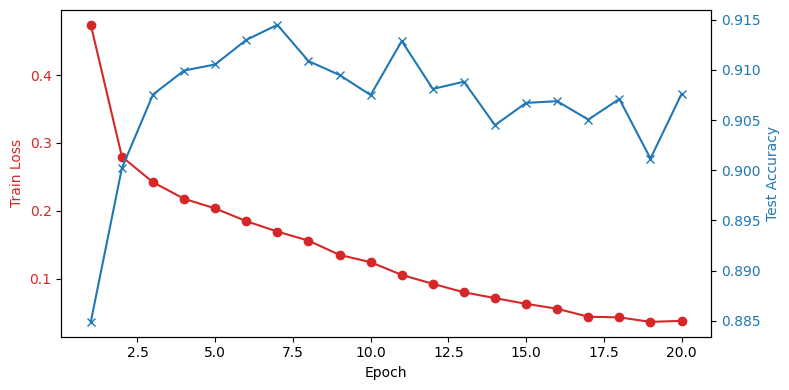

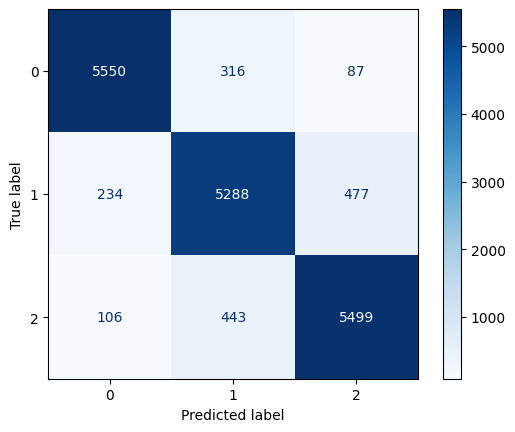

BiGRU Train Accuracy: 0.9076111111111111


In [41]:
gru_acc, gru_f1, gru_cm = train_model(model_gru, train_loader, test_loader, epochs=20, lr=1e-3)
print("BiGRU Train Accuracy:", gru_acc)
print("BiGRU Train Macro-F1:", gru_f1)

Evaluating: 100%|████████████████████████████| 563/563 [00:01<00:00, 544.29it/s]

Test Loss = 0.4937, Test Accuracy = 0.9076


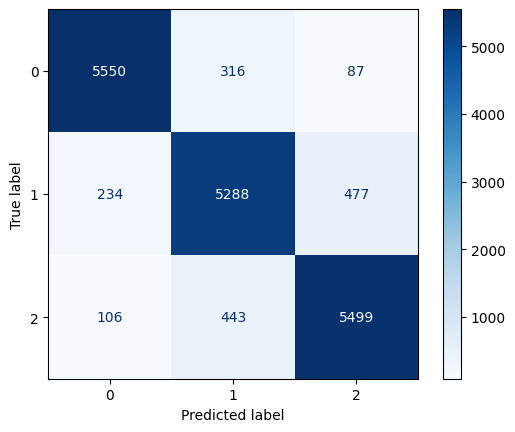

BiGRU Test Accuracy: 0.9076111111111111


In [42]:
test_acc, test_f1, test_cm = evaluate(model_gru, test_loader)
print("BiGRU Test Accuracy:", test_acc)
print("BiGRU Test Macro-F1:", test_f1)

**Оба варианта RNN, и LSTM, и GRU продемонстрировали метрики accuracy выше 90%.**